In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 5)
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


## Import Data

In [2]:
from matplotlib import dates as mdates

def load_sleep(file_loc):
    data = np.load(file_loc)
    pd_data = []
    
    time_offset = (1/100)/60/60/24
    formatter = mdates.DateFormatter('%m/%d/%Y %H:%M:%S.%f')
    for i in range(len(data)):
        d_row = data[i]
        for j in range(d_row[1]):
            row = {}
            #Sleep Data
            if d_row[6] == 0:
                continue
            elif d_row[6] == 1:
                stage = 'Stage 3'
                rem = 'NREM'
                depth = 'Deep'
            elif d_row[6] == 2:
                stage = 'Stage 2'
                rem = 'NREM'
                depth = 'Light'
            elif d_row[6] == 3:
                stage = 'Stage 1'
                rem = 'NREM'
                depth = 'Light'
            elif d_row[6] == 5:
                stage = 'REM'
                rem = 'REM'
                depth = 'REM'
            elif d_row[6] == 6:
                stage = 'AWAKE'
                rem = 'AWAKE'
                depth = 'AWAKE'
            else:
                stage = 'AWAKE'
                rem = 'AWAKE'
                depth = 'AWAKE'
            #row['Stage'] = stage
            #row['Depth'] = depth
            #row['REM'] = rem
            
            #Accel Data
            row['Time'] = formatter.format_data(d_row[0] + time_offset*j)
            row['Ax'] = ((d_row[2] - 128)/32) * 9.81
            row['Ay'] = ((d_row[3] - 128)/32) * 9.81
            row['Az'] = ((d_row[4] - 128)/32) * 9.81
            pd_data.append(row)
        
    data = pd.DataFrame(pd_data[::10])
    data['Am'] = (data.Ax**2 + data.Ay**2 + data.Az**2)**(1/2)
    #data = data.set_index(['REM', 'Depth', 'Stage', 'Time'])
    return data

In [3]:
#df = pd.read_csv('./test_sleep.csv')
df = load_sleep('./ICHI14_dataset/data/p003.npy')

In [4]:
df.head()


,Ax,Ay,Az,Time,Am
0,2.145938,-9.81,1.22625,05/10/2012 22:50:17.223019,10.116563
1,2.145938,-9.81,1.22625,05/10/2012 22:50:17.323018,10.116563
2,2.145938,-9.81,1.22625,05/10/2012 22:50:17.423018,10.116563
3,2.145938,-9.81,1.22625,05/10/2012 22:50:17.523017,10.116563
4,2.145938,-9.81,1.22625,05/10/2012 22:50:17.623017,10.116563


In [5]:
# Time is in intervals of about 1/10 of a second
ts = df.ix[:,['Time', 'Az']]
ts['Time'] = pd.to_datetime(ts['Time'])
ts.head()

,Time,Az
0,2012-05-10 22:50:17.223019,1.22625
1,2012-05-10 22:50:17.323018,1.22625
2,2012-05-10 22:50:17.423018,1.22625
3,2012-05-10 22:50:17.523017,1.22625
4,2012-05-10 22:50:17.623017,1.22625


## Plot Data

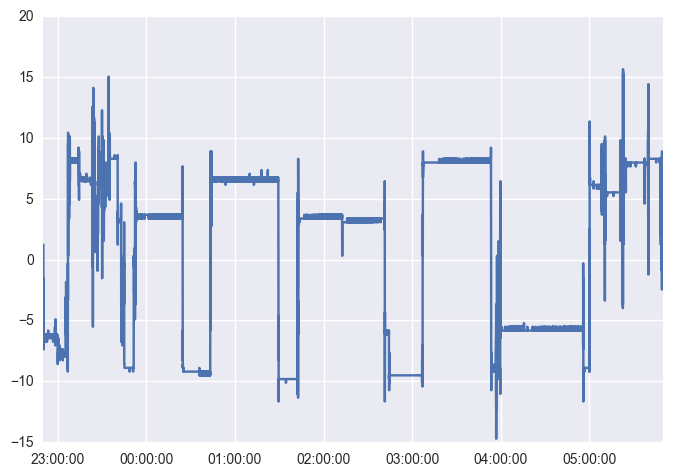

In [6]:
plt.plot(ts.Time, ts.Az)
plt.show()

## Analyze Data

In [7]:
# Get the windowed variances
def get_windowed_var(data, time, window_sec):
    variances = []
    times = []
    window = window_sec*10
    window_num = 0
    start = 0
    while window < len(data):
        var = np.var(data[start:window])
        variances.append(var)
        times.append(window_sec*window_num)
        window_num += 1
        start = window
        window += window_sec*10
    return variances, times

def get_windowed_mean(data, time, window_sec):
    means = []
    times = []
    window = window_sec*10
    window_num = 0
    start = 0
    while window < len(data):
        mean = np.mean(data[start:window])
        means.append(mean)
        times.append(window_sec*window_num)
        window_num += 1
        start = window
        window += window_sec*10
    return means, times

In [8]:
seconds = 1
z_var, t_1 = get_windowed_var(ts.Az, ts.Time, seconds)
z_mean, t_2 = get_windowed_mean(ts.Az, ts.Time, seconds)
print(len(t_1))
print(len(ts.Az))

25196
251967


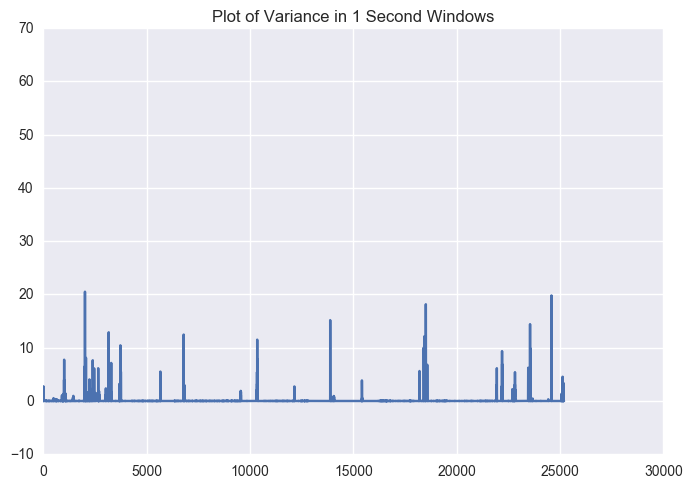

In [9]:
plt.plot(t_1, z_var)
plt.ylim([-10, 70])
plt.title("Plot of Variance in {} Second Windows".format(seconds))
plt.show()

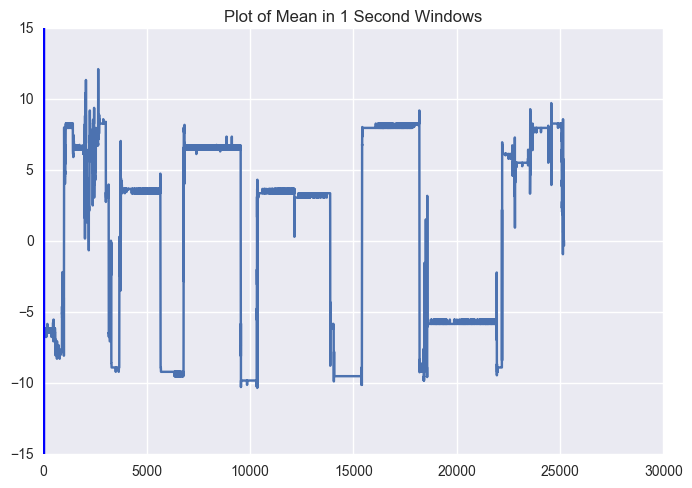

In [10]:
plt.plot(t_2, z_mean)
plt.axvline(55)
plt.title("Plot of Mean in {} Second Windows".format(seconds))
plt.show()

In [11]:
def find_window(data, index):
    for i in range(index, len(data)):
        if data[i] > 1:
            return i
    return i


def find_orientation_change(data, time, seconds, min_dist, min_mean_diff, min_duration):
    # Get variance and mean data
    var_data, t = get_windowed_var(data, time, seconds)
    mean_data = get_windowed_mean(data, time, seconds)[0]
    
    changes = []

    i = 0
    var_thresh = 5
    previous_change = 0
    previous_mean = 1000
    
    # If variance at i is less than 1, mark as possible orientation change
    while i < len(var_data):
        # Check if this is far enough from the last change to count
        if var_data[i] < var_thresh and i >= previous_change + min_dist:
            # Check if the mean is far enough from the previous mean
            mean_diff = abs(previous_mean - mean_data[i])
            
            if mean_diff >= min_mean_diff: 
                previous_mean = mean_data[i]
                j = find_window(var_data, i)
                if(abs(i-j) >= min_duration):
                    previous_change = j
                    changes.append([i*seconds, j*seconds])
                    i = j
                    
        elif var_data[i] < var_thresh and abs(previous_mean - mean_data[i]) <= min_mean_diff:
            j = find_window(var_data, i)
            changes[-1][1] = j*seconds 
            previous_change = j
            previous_mean = mean_data[i]
        
        i += 1
    
    return changes, var_data, mean_data, t

In [12]:
seconds = 60 #//2
min_dist = 5 #60//6
min_mean_diff = 1 #1
min_duration = 7 #10

changes, var_data, mean_data, t = find_orientation_change(ts.Az, ts.Time, seconds, 
                                                          min_dist, min_mean_diff, min_duration)

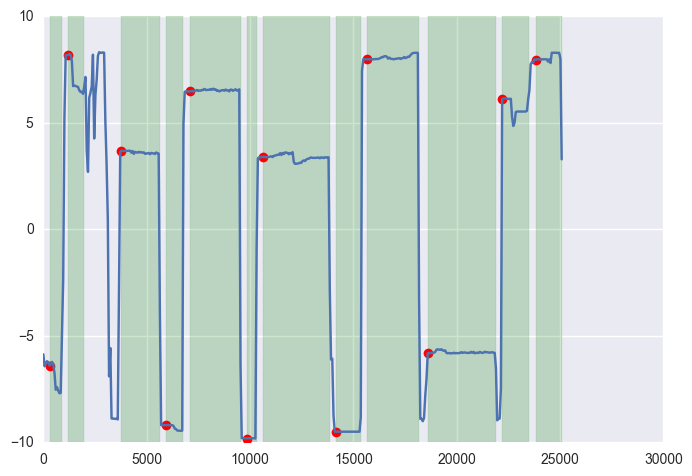

In [13]:
for c in changes:
    plt.axvspan(c[0] + 1, c[1] + 1, alpha = 0.2, color = 'g')
    plt.plot(c[0], mean_data[t.index(c[0])], 'or', )

plt.plot(t, mean_data)

plt.show()

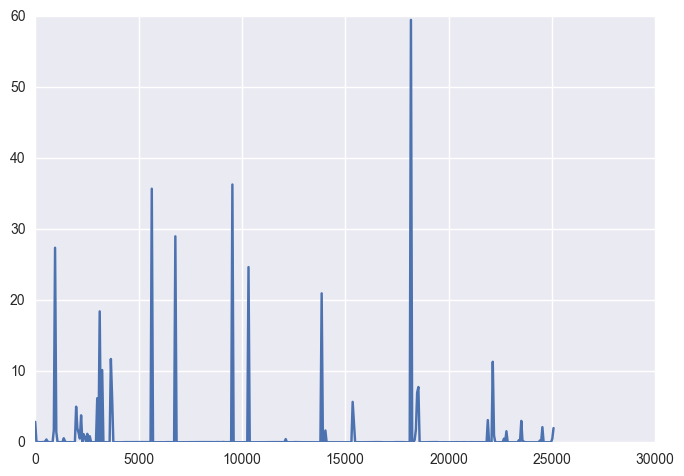

In [14]:
plt.plot(t, var_data)
plt.show()